In [1]:
import numpy as np
from math import pi
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import scipy.stats as ss
import matplotlib.pyplot as plt # gráficos

# Un modelo ingenuo de incertidumbre sobre el retorno de un portafolio que replica S&P

$$r_{t}=a_1r_{t-1}+\exp(\sigma_t)\sqrt{\frac{d-2}{d}}\xi_t\text{ con }\xi_t\stackrel{iid}{\sim}t(d)$$
$$\sigma_t = (1-\rho)\sigma+\rho\sigma_{t-1} + \epsilon_t\text{ con }\epsilon_t\stackrel{iid}{\sim}\mathcal{N}(0,\sigma_\epsilon^2)$$
$$r_{t}^{s\&p}=r_{t}+u_t\text{ con }u_t\stackrel{iid}{\sim}\mathcal{N}(0,\sigma_u^2)$$

note que este modelo es diferente a un modelo GARCH

## Cargemos la data

[*********************100%%**********************]  1 of 1 completed


--------------------------------------------------
S&P
            log-price  log-return
2005-01-04   4.414028   -0.012295
2005-01-05   4.407104   -0.006925
2005-01-06   4.412175    0.005072
2005-01-07   4.410741   -0.001435
2005-01-10   4.415458    0.004717


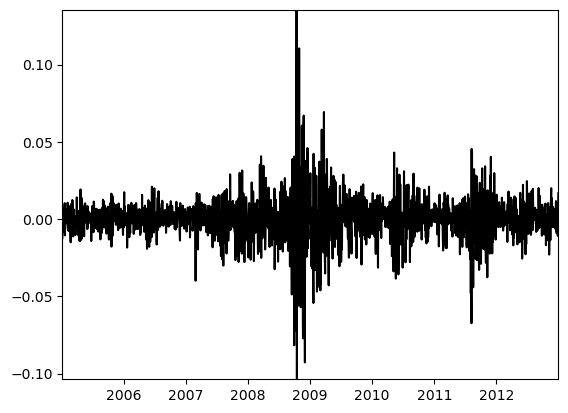

In [2]:
start = dt.datetime(2005,1,1)
end   = dt.datetime(2013,1,1)
#SPY   = web.DataReader("SPY", 'yahoo', start=start, end=end)['Adj Close']
import yfinance as yf
SPY = yf.download("SPY", start=start, end=end)['Adj Close']
lp    = np.log(SPY)
lr    = np.log(SPY/SPY.shift(1))
spydf = pd.concat([lp,lr],axis=1).dropna(axis=0)
spydf.columns = ['log-price','log-return']
spydf.index = pd.DatetimeIndex(spydf.index.values,freq=spydf.index.inferred_freq)
print('-'*50)
print('S&P')
print(spydf.head())
fig, axs = plt.subplots(1,1)
axs.plot(spydf['log-return'],'k')
axs.autoscale(enable=True, axis='both', tight=True)

In [3]:
data = spydf['log-return'].values
data = data - np.mean(data)
nobs = data.size
data = np.reshape(data,(nobs,1))

## Representación de SS
Según la notación del texto

* variable medible: $\mathbf{y}_t=r_{t}^{s\&p}$
* Errores de medida: $\mathbf{u}_t=u_{t}$
* variables de estado: $\boldsymbol{\alpha}_t=[r_t,\ \sigma_t]'$
* Errores de estado: $\boldsymbol{\epsilon}_t=[\xi_t,\ \epsilon_{t}]'$
* Coeficientes del modelo: $\boldsymbol{\theta}=[a_1,\ \theta,\ \rho,\ d,\ \sigma_\epsilon^2,\ \sigma_u^2]$
* Sistema de medida: $\Psi(\boldsymbol{\alpha}_t,t,\boldsymbol{\theta})=\begin{bmatrix}r_{t}\end{bmatrix}$
* Sistema de estados: $\Phi(\boldsymbol{\alpha}_{t-1},\boldsymbol{\epsilon}_t,\boldsymbol{\theta})=\begin{bmatrix}
a_1r_{t-1}+\exp(\sigma_t)\sqrt{\frac{d-2}{d}}\xi_t\\
(1-\rho)\sigma+\rho\sigma_{t-1} + \epsilon_t\end{bmatrix}$
* Distribución de errores de medida: $F_{\mathbf{u}}(\cdot|\boldsymbol{\theta}): \mathcal{N}(0,\sigma_u^2)$
* Distribución de errores de estado: $F_{\boldsymbol{\epsilon}}(\cdot|\boldsymbol{\theta}): \begin{bmatrix}t(d)\\ \mathcal{N}(0,\sigma_\epsilon^2)\end{bmatrix}$

Calibración inicial de parámetros

In [4]:
# Measurement error = 10% of data SD
sigmau2_0 = (np.sqrt(np.var(data))*0.1)**2

# Persistence in S&P data
yt = data[1:]
ylag = data[0:-1]
xx = np.transpose(ylag)@ylag
xy = np.transpose(ylag)@yt
a1_0      = (np.linalg.inv(xx).item())*(xy).item()

# DoF: arbitrary choice by now
d_0 = 10

# Error from AR(1) in S&P
aux0    = yt - a1_0*ylag
aux0    = (np.sqrt(d_0/(d_0-2)).item())*aux0

# Estimator of exp(sigma(t))
expsigmahat   = np.abs(aux0)


# Estimator of sigma(t)
sigmahat = np.log(expsigmahat)


# Estimator of sigma=mean(sigma(t))
sigma_0  = np.mean(sigmahat).item()

# Estimator of persistence of sigma(t)
yt = sigmahat[1:]
ylag = sigmahat[0:-1]
xx = np.transpose(ylag)@ylag
xy = np.transpose(ylag)@yt
rho_0     = (np.linalg.inv(xx).item())*(xy).item()

# Estimator of epsilon(t)
ehat    = sigmahat[1:] - (1-rho_0)*sigma_0 - rho_0*sigmahat[0:-1]


# Estimator of sigmae2 = var(epsilon(t))
sigmaepsilon2_0 = np.var(ehat).item()*0.5


# theta0
theta_0 = np.ndarray(shape=(6,1))
theta_0[0] = a1_0
theta_0[1] = sigma_0
theta_0[2] = rho_0
theta_0[3] = d_0
theta_0[4] = sigmaepsilon2_0
theta_0[5] = sigmau2_0

## Funciones relacionadas al procedimiento del filtro de partículas bootstrap

Sistema de medidas

$$\Psi(\boldsymbol{\alpha}_t,t;\boldsymbol{\theta}):\text{ de }\mathbf{y}_t=\Psi(\boldsymbol{\alpha}_t,t;\boldsymbol{\theta})+\mathbf{u}_t$$

* $\boldsymbol{\alpha}_t$ es una matriz de orden $N\times n_s$ donde $N$ es el número de partículas y $n_s$ es el número de variables de estado
* $\boldsymbol{\theta}=[a_1,\ \theta,\ \rho,\ d,\ \sigma_\epsilon^2,\ \sigma_u^2]$ es de orden $6\times1$
* $\mathbf{y}_t$ es una matriz de orden $N\times n_y$ donde $n_y$ es el número de variables medibles

In [5]:
def Psi(aa,tt,th): 
    N,ns = aa.shape
    rt = np.reshape(aa[:,0],(N,1))
    return rt

Sistema de estados
$$\Phi(\boldsymbol{\alpha}_{t-1},\boldsymbol{\epsilon}_{t};\boldsymbol{\theta}):\text{ de }\boldsymbol{\alpha}_{t}=\Phi(\boldsymbol{\alpha}_{t-1},\boldsymbol{\epsilon}_{t};\boldsymbol{\theta})$$

* $\boldsymbol{\epsilon}_t$ es una matriz de orden $N\times n_r$ donde $n_r$ es el número de choques de estado

In [6]:
def Phi(aalag,ee,th): 
    # Unpack coefficients
    a1        = th[0]
    sigma     = th[1]
    rho       = th[2]
    d         = th[3]
    sigmaepsilon2 = th[4]
    sigmau2   = th[5]
    # Unpack states
    N,ns      = aalag.shape
    rlag      = np.reshape(aalag[:,0],(N,1))
    sigmalag  = np.reshape(aalag[:,1],(N,1))
    # Unpack states shocks
    xit       = np.reshape(ee[:,0],(N,1))
    epsilont  = np.reshape(ee[:,1],(N,1))
    # new states
    sigmat    = (1-rho)*sigma + rho*sigmalag + epsilont
    rt        = a1*rlag + np.exp(sigmat)*(np.sqrt((d-2)/d).item())*xit
    aa        = np.ndarray(shape=aalag.shape)
    aa[:,0]   = np.reshape(rt,(N,))
    aa[:,1]   = np.reshape(sigmat,(N,))
    return aa

Función para calcular PDF de errores de medida

$$\mathbf{u}_t=u_t\stackrel{iid}{\sim}\mathcal{N}(0,\sigma_u^2)$$

* $u_t$ es una matrix de orden $N\times1$

In [7]:
def pdfFu(u,th):
    sigmau2   = th[5]
    return (1/(np.sqrt(2*pi*sigmau2)))*np.exp( -(1/2)*(u**2)/sigmau2 )

Función para simular errores de estado: Particulas
$$\boldsymbol{\epsilon}_t=\begin{bmatrix}\xi_t & \epsilon_{t}\end{bmatrix}\text{ con }F_{\boldsymbol{\epsilon}}(\cdot|\boldsymbol{\theta}): \begin{bmatrix}t(d) & \mathcal{N}(0,\sigma_\epsilon^2)\end{bmatrix}$$
* $\boldsymbol{\epsilon}_t$ es una matriz de orden $N\times2$

In [8]:
def randFe(n,th):
    # Unpack coefficients
    d             = th[3]
    sigmaepsilon  = np.sqrt(th[4]).item()
    ernd = np.ndarray(shape=(n,2))
    ernd[:,0] = np.random.standard_t(d, size=(n,))
    ernd[:,1] = sigmaepsilon*np.random.randn(n,)
    return ernd

## Dimensiones en la recursión

In [9]:
ns         = 2  # Número de estados
nr         = 2  # Número de residuos
ny         = 1  # Número de medibles
N          = 10000 # Número de partículas
T          = data.size # Número de observaciones

## Recursión

0. Generando espacio en la memoria

In [10]:
all_alpha_00  = np.zeros((T, ns, N)) # Actualización de estados
lik           = np.zeros((T,1));     # Vector de verosimilitudes
Neff          = np.zeros((T,1));     # Número de partículas efectivas

1. Inicialización

El estado estacionario es: $r_{ss}=0$ y $\sigma_{ss}=\sigma$ las particulas iniciales se simularán desde:
$$\sigma_0\sim\mathcal{N}\left(\sigma,\sigma_\epsilon^2\right)$$
$$\frac{r_0}{\exp(\sigma_0)}\sqrt{\frac{d}{d-2}}\sim\mathcal{t}(d)$$

In [11]:
# Coeficientes calibrados (en esta aplicación simplemente igual a los iniciales)
theta = theta_0

In [12]:
# Unpack coefficients
a1            = theta[0]
sigma         = theta[1]
rho           = theta[2]
d             = theta[3]
sigmaepsilon2 = theta[4]
sigmau2       = theta[5]

In [13]:
# Simulando sigma_0|0
sigma_00 = sigma.item() + (np.sqrt(sigmaepsilon2).item())*np.random.randn(N,1) # Dimensiones: Nx1 (N=# de partículas)
# Simulando r_0|0
aux0 = np.random.standard_t(d, size=(N,1))
r_00 = (np.sqrt((d-2)/d).item())*np.exp(sigma_00)*aux0
# Apilando estados
alpha_00 = np.ndarray(shape=(N,2))
alpha_00[:,0] = np.reshape(r_00,(N,))
alpha_00[:,1] = np.reshape(sigma_00,(N,))

In [14]:
alpha_00

array([[-2.85881340e-03, -6.19623845e+00],
       [-3.32570304e-02, -3.86673492e+00],
       [-7.75504789e-04, -5.80111263e+00],
       ...,
       [-3.09527915e-04, -5.33686967e+00],
       [ 3.44637836e-03, -5.57595014e+00],
       [-7.74311215e-03, -3.51640797e+00]])

Fijar los pesos en $W=1$

In [15]:
WW = np.ones(shape=(N,1))

2. Recursión

In [16]:
np.random.seed( 0 ) # Fijando la semilla (reproducir resultados)
for tt in range(T):
    WWnanflag = True
    while WWnanflag:
        # Simula residuos de estado
        epsilont = randFe(N,theta)
        # Predecir alpha
        alpha_10 = Phi(alpha_00,epsilont,theta)
        # Predecir las variables medibles
        yt_10 = Psi(alpha_10,1,theta)
        # Calcular pesos incrementales
        yt = data[0,:]
        perror  = np.tile(yt,(N,1)) - yt_10
        ww = pdfFu(perror,theta)
        # Densidad predictiva
        lik[tt,0] = np.mean(ww*WW).item()
        all_alpha_00[tt,:,:] = np.reshape(np.transpose(alpha_00),(1,2,N))
        # Pesos normalizados
        W0 = (ww*WW)/(np.mean(ww*WW).item())
        if np.any(np.isnan(W0)):
            WWnanflag = True
        else:
            WWnanflag = False
            WW = W0
            # Tamaño efectivo de muestra
            Neff[tt,0] = (N**2)/(np.sum(WW**2).item())
            # Remuestreo si necesario
            if Neff[tt,0] <= N/2:
                newindex = np.random.randint(0, N, size=(N,1))
                alpha_00 = np.reshape(alpha_10[newindex,:],(N,2))  # Resampling if ESS falls below a threshold
                WW       = np.ones(shape=(N,1))
            else:
                alpha_00 = alpha_10
            
        

## Mostrando algunos resutados

1. La verosimilitud


In [17]:
dat = {'Log-verosimilitud': np.reshape(lik,(T,)).tolist(), 'Tamaño efectivo de muestra': np.reshape(lik,(T,)).tolist()}
res0 = pd.DataFrame(data=dat, index=spydf.index)

In [18]:
res0['Log-verosimilitud']

2005-01-04    6.869324
2005-01-05    6.595924
2005-01-06    5.777055
2005-01-07    5.348455
2005-01-10    5.092549
                ...   
2012-12-24    4.191854
2012-12-26    3.497517
2012-12-27    3.755029
2012-12-28    3.716280
2012-12-31    3.420251
Name: Log-verosimilitud, Length: 2012, dtype: float64

La verosimilitud de la muestra es 3.8712333131089673


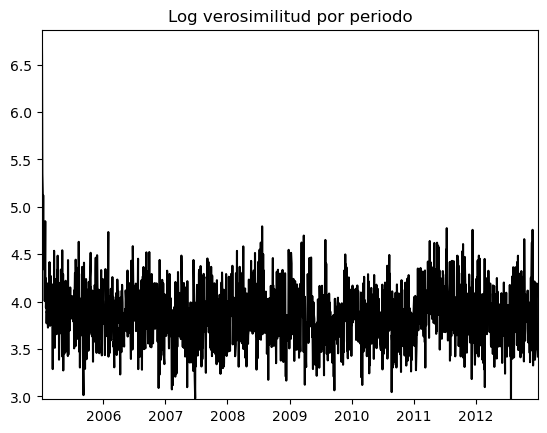

In [19]:
fig, axs = plt.subplots(1,1)
axs.plot(res0['Log-verosimilitud'],'k')
axs.autoscale(enable=True, axis='both', tight=True)
axs.set_title('Log verosimilitud por periodo')
print('La verosimilitud de la muestra es',np.mean(lik).item())

2. Número effectivo de partícular

Text(0.5, 1.0, 'Tamaño efectivo de muestra por periodo')

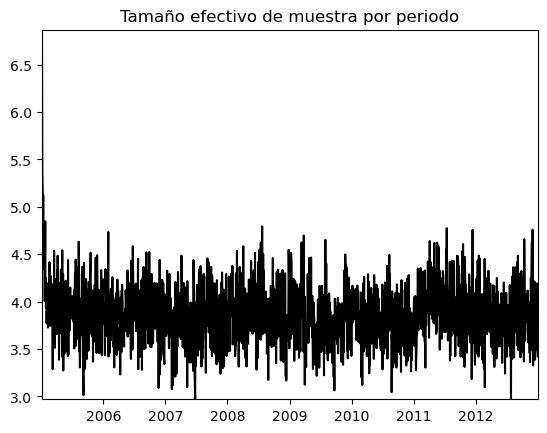

In [20]:
fig, axs = plt.subplots(1,1)
axs.plot(res0['Tamaño efectivo de muestra'],'k')
axs.autoscale(enable=True, axis='both', tight=True)
axs.set_title('Tamaño efectivo de muestra por periodo')

2. Los estados

In [21]:
alpha_mean = np.percentile(all_alpha_00, 50, axis=-1)
alpha_Q005 = np.percentile(all_alpha_00, 5, axis=-1)
alpha_Q095 = np.percentile(all_alpha_00, 95, axis=-1)

dat = {'r_mean': np.reshape(alpha_mean[:,0],(T,)).tolist(), 
       'r_Q005': np.reshape(alpha_Q005[:,0],(T,)).tolist(), 
       'r_Q095': np.reshape(alpha_Q095[:,0],(T,)).tolist(),       
       'sigma2_mean': np.reshape(np.exp(alpha_mean[:,1]),(T,)).tolist(), 
       'sigma2_Q005': np.reshape(np.exp(alpha_Q005[:,1]),(T,)).tolist(), 
       'sigma2_Q095': np.reshape(np.exp(alpha_Q095[:,1]),(T,)).tolist()}
estados = pd.DataFrame(data=dat, index=spydf.index)
estados

,r_mean,r_Q005,r_Q095,sigma2_mean,sigma2_Q005,sigma2_Q095
2005-01-04,-8.775380e-06,-0.018322,0.017492,0.005253,0.000827,0.032157
2005-01-05,-1.403030e-05,-0.024765,0.027011,0.005138,0.000391,0.061895
2005-01-06,-2.777630e-05,-0.040422,0.036212,0.005009,0.000240,0.106140
2005-01-07,1.011009e-06,-0.054978,0.051593,0.004908,0.000166,0.174777
2005-01-10,-1.258982e-05,-0.063703,0.068224,0.004807,0.000116,0.234745
...,...,...,...,...,...,...
2012-12-24,5.776755e-08,-0.309035,0.271235,0.003533,0.000007,1.905601
2012-12-26,-2.927665e-08,-0.289275,0.288321,0.003822,0.000008,1.908876
2012-12-27,4.018128e-08,-0.318249,0.340341,0.003865,0.000007,2.078779
2012-12-28,-5.757924e-07,-0.316977,0.404108,0.003888,0.000008,1.989235


Text(0.5, 1.0, 'Tasa de retorno')

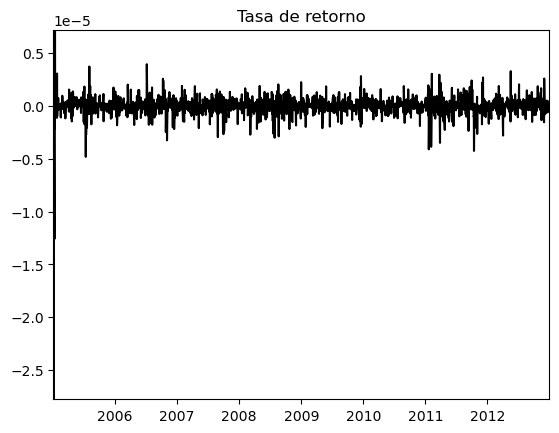

In [22]:
fig, axs = plt.subplots(1,1)
axs.plot(estados['r_mean'],'k')
#axs.plot(estados['r_Q005'],'--r')
#axs.plot(estados['r_Q095'],'--r')
axs.autoscale(enable=True, axis='both', tight=True)
axs.set_title('Tasa de retorno')

Text(0.5, 1.0, 'Volatilidad')

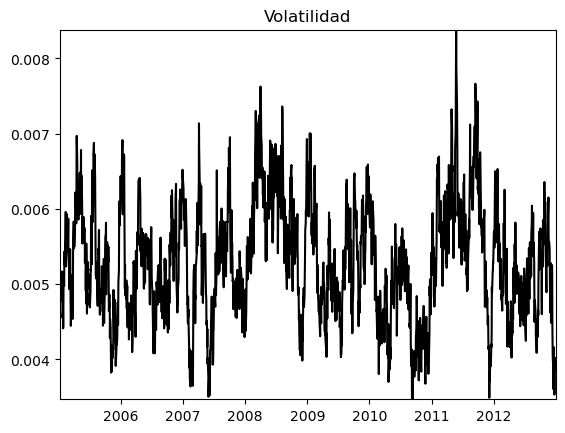

In [23]:
fig, axs = plt.subplots(1,1)
axs.plot(estados['sigma2_mean'],'k')
#axs.plot(estados['sigma2_Q005'],'--r')
#axs.plot(estados['sigma2_Q095'],'--r')
axs.autoscale(enable=True, axis='both', tight=True)
axs.set_title('Volatilidad')

In [24]:
print('La verosimilitud de la muestra es',np.mean(lik).item())

La verosimilitud de la muestra es 3.8712333131089673
